### Load in initial packages

In [235]:
import pandas as pd
import oscn
import nltk
from bs4 import BeautifulSoup
import re
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#Uncomment on initial run -- #nltk.download('punkt')
from tqdm import tqdm
from difflib import SequenceMatcher
import pickle

In [236]:
#!pip install sklearn-crfsuite
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
from sklearn.model_selection import KFold, StratifiedKFold

## Lookup Docket Functions

In [237]:
def lookUpDocket(docNum):
    splitNum = docNum.split('-')
    #print(splitNum)
    docType = splitNum[0]
    year = splitNum[1]
    county ='Tulsa'
    docNum = splitNum[2]
    #print("Split: ", docType, ' ', year, ' ', docNum)
    case=oscn.request.Case(type=docType, year=year,county=county,number=docNum)
    return case

#### Pulling out Judge, defendant lawyer & state rep from given text

Commented out all of the print functions, so the execution of the code below isn't so lengthy

In [238]:
def matchTagPatterns(string, pattern):
    match_list = []
    #print("Pattern is ",pattern)
    pattern = re.sub(r'[^\w\s]','',pattern)
    pattern = pattern.strip()
    #print("Stripped Pattern: ",pattern)
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
        
    return match_list, string

def mark_sentence(s, match_list):
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'
        
    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def clean(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = re.sub(r'[^\w\s]','',text)
    return text

def create_data(df):
    match_list = []
    for text, annotation in zip(df.text, df.annotation):
        #print("Text : ", text)
        #print("annotation : ", annotation)
        text = clean(text)
        #print("text cleaned")
        text_ = text 
        #print(text_)

        for i in annotation:
            a, text_ = matchTagPatterns(text, i[0])
            #print('a:',a)
            #print('i:',i)
            if a:
                match_list.append((a[0][0], a[0][1], i[1]))
    d = mark_sentence(text, match_list)
    return d

#### Creating tuples and tagging out the keywords we want to identify

This sets up the data into easier to use pairs of `(word, tag)`

In [239]:
def createTuples(i, value, column):
    values = value.split('\n')
    tuples = []
    for val in values:
        tuples.append(tuple((val,column)))
    #print("found tuples ",tuples," for ", value)
    return tuples
#Tuple reference
#https://stackoverflow.com/questions/31175223/append-a-tuple-to-a-list-whats-the-difference-between-two-ways/31175264
def getValues(i,column):
    value = training[column][i]
    tuples = []
    #print("Values ", value, " found ", pd.isnull(value), " is null for column ",column)
    if not(pd.isnull(value)):
        if ('\n' in value):
            tuples = createTuples(i, value, column)
        else:
            tuples.append(tuple([value,column]))
    #print("tuple created ", tuples)
    return tuples
def zipTuples(lst):
    lst_tuple = [x for x in zip(*[iter(lst)]*2)]
    #print(lst_tuple)
    return lst_tuple
def getAnnotations(i, columns):
    annotations = []
    for column in columns:
        tuples = getValues(i,column)
        #print("tuples created =", tuples, " tuples")
        annotations = np.append(annotations,[[tuples]]) 
        #print("annotations created =", annotations, " annotations")
    return zipTuples(annotations)
        
def getTags(case,i):
    #print("This is the ",i,"th case")
    columns = ['Judge','Defendant lawyer','State Rep']
    annotations = getAnnotations(i, columns)
    tags = [[case.text, annotations]]
    return tags

## Features, Tokens, and Label Lists

Features used by the CRF Model, but not the eventual LSTM Neural Network. 

In [240]:
def word2features(sent, i):
    word = sent[i][0]
    #postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        #postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        #postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [241]:
def tagsToSent(tags):
    sentList = []
    for i in range(len(tags)):
        #https://www.kite.com/python/answers/how-to-convert-a-dictionary-into-a-list-of-tuples-in-python
        #print(tags[i].items())
        dictItems = tags[i].items()
        sentList.append(list(dictItems))
    return sentList

## Running Dockets through Tagger 

### Pulling in the Training Data

* If you've got the pickled file `taggedNERSet`  and want to see setup for NN, then you can skip to the Word Mapping section
* If you've got the pickled files `X`,`y`,`X_val`,`y_val`, you can skip to the Bidirectional LSTM section where the Neural Network modelling starts

In [242]:
#Load in data
training = pd.read_csv('../../Data/judge_training_labels.csv')
training.head()

,Docket Number,Conviction,NER Training Paragraph,Judge,Defendant lawyer,State Rep,Sentencing,Link,Year
0,CF-2012-5905,Y,JUDGE DAWN MOODY: DEFENDANT PRESENT NOT IN CUS...,DAWN MOODY,SHEILA NAIFEH,JULIANNE BURTON,TWO (2) YEARS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
1,CF-2012-5896,Y,JUDGE JAMES CAPUTO: DEFENDANT PRESENT REPRESEN...,JAMES CAPUTO,DARRELL BOLTON,KALI STRAIN,TWO (2) YEARS DEPARTMENT OF CORRECTIONS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
2,CF-2012-5886,Y,JUDGE JAMES CAPUTO: DEFENDANT PRESENT IN CUSTO...,JAMES CAPUTO,ADAM HASELGREN,KALI STRAIN,THREE (3) YEARS IN DEPARTMENT OF CORRECTIONS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
3,CF-2012-5591,N,JUDGE CLIFFORD SMITH: DEFENDANT PRESENT IN CUS...,CLIFFORD SMITH,CLAY IJAMS,SEAN HILL,STATE DISMISSES,https://www.oscn.net/dockets/GetCaseInformatio...,2012
4,CF-2012-5914,Y,\nJUDGE STEPHEN CLARK: DEFENDANT PRESENT NOT I...,STEPHEN CLARK,CARLOS WILLIAMS,ERIC LOGGIN,FIVE (5) YEAR DEFERRED SENTENCE\nFIVE (5) YEAR...,https://www.oscn.net/dockets/GetCaseInformatio...,2012


In [243]:
#Reviewing the one record to validate
#training.iloc[[n]]

Example of usage of the `lookUpDocket` function using the first row's Docket Number column

In [244]:
#Parse out the Docket number using the above function
#testNum = training['Docket Number'][0]
#case = lookUpDocket(testNum) #training['Docket Number'][0]
#case

Example of usage of the `word_tokenize`

In [245]:
#Return a tokenized copy of text
#tokenizedCase = word_tokenize(case.text)
#tokenizedCase

### Pulling out the Judge, Defendant Lawyer & State Rep from training set

In [246]:
allTags =[]
for i in training.index:
    case = lookUpDocket(training['Docket Number'][i])
    data = pd.DataFrame(getTags(case,i), columns=['text', 'annotation'])
    taggedSet = create_data(data)
    allTags.append(taggedSet)
#allTags[0]

#### Converting a dictionary into a list of tuples

`tagsToSent` takes the given tagged dictionary for each document and turns them into a list form. This `sentList` is now a list of lists that represent a single OSCN document's text: 

`[document1,document2...]`

Sentences are the normal way documents are broken up and tagged. We are treating each OSCN document as a 'sentence' to keep documents together and for ease of assigning the entities to a case number. Each of these documents are made up of tagged word lists in tuple form:

`[('OSCN','O'),...,('JANE', 'B-State Rep'), ('DOE', 'I-State Rep'),...]`

In [247]:
sentList = tagsToSent(allTags)
#sentList[0]

In [248]:
# Pickle tagged data for later runs without invoking the OSCN scraper
file_name = f'taggedNERSet'
f = open(file_name, 'wb')
pickle.dump(sentList, f)
f.close()

In [249]:
#Use pickled data from above tagging
file_name = f'taggedNERSet'
sentList2 = pickle.load(open(file_name, 'rb'))
#testing load to new list to ensure we actually saved and reloaded
#sentList2[0]

## Running against a CRF Model

Just for mechanics sake seeing if we've gotten the data into a state that it can be manipulated by a model (that's why test and train are the same set) Run the above cell that loads processed training data into sentList2

In [250]:
%%time
X_train = [sent2features(s) for s in sentList2]
y_train = [sent2labels(s) for s in sentList2]

#test is same as train just for functionality testing
X_test = [sent2features(s) for s in sentList2]
y_test = [sent2labels(s) for s in sentList2]

Wall time: 579 ms


In [251]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 10.5 s


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

Looking at just the non-O taggs from the CRF Model

In [252]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-Judge',
 'I-Judge',
 'B-State Rep',
 'I-State Rep',
 'B-Defendant lawyer',
 'I-Defendant lawyer']

In [253]:
y_pred = crf.predict(X_test)

In [254]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                    precision    recall  f1-score   support

B-Defendant lawyer      0.954     0.907     0.930       205
I-Defendant lawyer      0.956     0.894     0.924       218
           B-Judge      0.938     0.838     0.885       198
           I-Judge      0.950     0.805     0.872       236
       B-State Rep      0.974     0.918     0.945       207
       I-State Rep      0.964     0.905     0.934       210

         micro avg      0.956     0.877     0.915      1274
         macro avg      0.956     0.878     0.915      1274
      weighted avg      0.956     0.877     0.914      1274



# Word Mapping

Load in the previous run pickle data which includes the 3 key columns to train the model on in the right format 

In [255]:
#Use pickled data from above tagging
file_name = f'taggedNERSet'
sentList2 = pickle.load(open(file_name, 'rb'))

In [256]:
#sentList2[55]

In [257]:
#sentList
X_train = [sent2tokens(s) for s in sentList2]
y_train = [sent2labels(s) for s in sentList2]

#test is same as train just for functionality testing
X_test = [sent2tokens(s) for s in sentList2]
y_test = [sent2labels(s) for s in sentList2]

In [258]:
#X_train[1]

In [259]:
for i in zip(X_train[1],y_train[1]):
    print(i)

('OSCN', 'O')
('Case', 'O')
('Details', 'O')
('Skip', 'O')
('to', 'O')
('Main', 'O')
('Content', 'O')
('Accessibility', 'O')
('Statement', 'O')
('Help', 'O')
('Contact', 'O')
('Us', 'O')
('epayments', 'O')
('Careers', 'O')
('toggle', 'O')
('navigation', 'O')
('Home', 'O')
('Courts', 'O')
('Decisions', 'O')
('Programs', 'O')
('News', 'O')
('Legal', 'O')
('Research', 'O')
('Court', 'O')
('Records', 'O')
('Quick', 'O')
('Links', 'O')
('The', 'O')
('information', 'O')
('on', 'O')
('this', 'O')
('page', 'O')
('is', 'O')
('NOT', 'O')
('an', 'O')
('official', 'O')
('record', 'O')
('Do', 'O')
('not', 'O')
('rely', 'O')
('the', 'O')
('correctness', 'O')
('or', 'O')
('completeness', 'O')
('of', 'O')
('Verify', 'O')
('all', 'O')
('with', 'O')
('keeper', 'O')
('contained', 'O')
('in', 'O')
('report', 'O')
('provided', 'O')
('compliance', 'O')
('Oklahoma', 'O')
('Open', 'O')
('Act', 'O')
('51', 'O')
('OS', 'O')
('24A1', 'O')
('Use', 'O')
('governed', 'O')
('by', 'O')
('act', 'O')
('as', 'O')
('well

In [260]:
from collections import Counter
words = []
for entry in X_train:
    for word in entry:
        words.append(word)

In [261]:
#Unique words counted in the dockets, then mapping the words to a number (which will then be used in the NN)
wc = Counter(words)
len(wc)

15830

In [262]:
word_map = {}
for i,(k,v) in enumerate(wc.most_common()):
    word_map[k] = i+2 #starting sequence after unknowns
word_map['<pad>']=0 #padding values
word_map['<unk>']=1 #unknown values

In [263]:
word_map

{'OSCN': 2,
 'Case': 3,
 'Details': 4,
 'Skip': 5,
 'to': 6,
 'Main': 7,
 'Content': 8,
 'Accessibility': 9,
 'Statement': 10,
 'Help': 11,
 'Contact': 12,
 'Us': 13,
 'epayments': 14,
 'Careers': 15,
 'toggle': 16,
 'navigation': 17,
 'Home': 18,
 'Courts': 19,
 'Decisions': 20,
 'Programs': 21,
 'News': 22,
 'Legal': 23,
 'Research': 24,
 'Court': 25,
 'Records': 26,
 'Quick': 27,
 'Links': 28,
 'The': 29,
 'information': 30,
 'on': 31,
 'this': 32,
 'page': 33,
 'is': 34,
 'NOT': 35,
 'an': 36,
 'official': 37,
 'record': 38,
 'Do': 39,
 'not': 40,
 'rely': 41,
 'the': 42,
 'correctness': 43,
 'or': 44,
 'completeness': 45,
 'of': 46,
 'Verify': 47,
 'all': 48,
 'with': 49,
 'keeper': 50,
 'contained': 51,
 'in': 52,
 'report': 53,
 'provided': 54,
 'compliance': 55,
 'Oklahoma': 56,
 'Open': 57,
 'Act': 58,
 '51': 59,
 'OS': 60,
 '24A1': 61,
 'Use': 62,
 'governed': 63,
 'by': 64,
 'act': 65,
 'as': 66,
 'well': 67,
 'other': 68,
 'applicable': 69,
 'state': 70,
 'and': 71,
 'feder

In [264]:
#Pulling out the tag map that we want to focus on training the data on ( 0 = unknown/pad )
## Does the label/ordering of this map matter?
tags = []
for entry in y_train:
    for tag in entry:
        tags.append(tag)
tags = list(set(tags))

tag_map = {}
for i,v in enumerate(tags):
    tag_map[v] = i+1
    tag_map[0] = 0
    
tag_map

{'I-State Rep': 1,
 0: 0,
 'B-Judge': 2,
 'I-Judge': 3,
 'B-Defendant lawyer': 4,
 'B-State Rep': 5,
 'I-Defendant lawyer': 6,
 'O': 7}

In [265]:
X=[]
y=[]
for sent in X_train:
    X.append([word_map[i] for i in sent])
for seq in y_train:
    y.append([tag_map[i] for i in seq])
X_val = []
y_val = []

#TO DO: Actual Train Test Split
for sent in X_test:
    X_val.append([word_map[i] if i in word_map.keys() else 1 for i in sent])
for seq in y_test:
    y_val.append([tag_map[i] for i in seq])

In [266]:
#This is calling just the index within the wordmap, because NN can only handle numbers
#X[0]

In [267]:
print(max([len(i) for i in X]))

1243


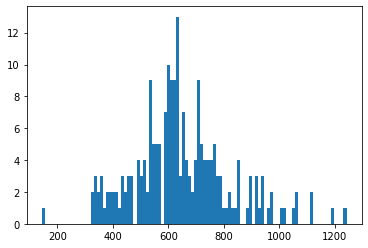

In [268]:
#Looking at the distribution of data
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([len(i) for i in X],bins=100)
plt.show()

In [269]:
#In order to achieve a confidence interval, select the quartile for the model to train on
import numpy as np
print(np.quantile([len(i) for i in X],0.75))
print(np.quantile([len(i) for i in X],0.95))
print(np.quantile([len(i) for i in X],0.99))

736.0
964.4999999999998
1119.6399999999999


In [270]:
max_len = 1000
from tensorflow.keras.preprocessing import sequence

#Preparing the data for Neural Net (padding the data to be all the same length)
X = sequence.pad_sequences(X, maxlen=max_len)
y = sequence.pad_sequences(y, maxlen=max_len)
X_val = sequence.pad_sequences(X_val, maxlen=max_len)
y_val = sequence.pad_sequences(y_val, maxlen=max_len)

## Storing final processed datasets

In [271]:
%store X
%store y
%store X_val
%store y_val

Stored 'X' (ndarray)
Stored 'y' (ndarray)
Stored 'X_val' (ndarray)
Stored 'y_val' (ndarray)


In [272]:
# X
f = open('X', 'wb')
pickle.dump(X, f)
f.close()
# y
f = open('y', 'wb')
pickle.dump(y, f)
f.close()
# X_val
f = open('X_val', 'wb')
pickle.dump(X_val, f)
f.close()
# y_val
f = open('y_val', 'wb')
pickle.dump(y_val, f)
f.close()

In [273]:
#example of a padded sentence (with leading 0s)
#X[0]

# Bidirectional LSTM
TODO: word_map is also required to run

In [274]:
#Unpickle our
# X
X = pickle.load(open('X', 'rb'))
# y
y = pickle.load(open('y', 'rb'))
#Since we are using 5 fold Cross Validation and have a small training set, this is currently just the training set
# X_val
X_val = pickle.load(open('X_val', 'rb'))
# y_val
y_val = pickle.load(open('y_val', 'rb'))

In [275]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Test NN to ensure our data is setup properly

In [276]:
safety = EarlyStopping(monitor='val_loss', patience=1)
# create the model
word_vector_len = 100
model1 = Sequential()
model1.add(Embedding(len(word_map), word_vector_len, input_length=max_len))
model1.add(Bidirectional(LSTM(256, return_sequences=True)))
model1.add(Dropout(0.25))
model1.add(TimeDistributed(Dense(len(tag_map),activation='softmax')))

In [277]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### What does non-trainable parameters mean? is there a threshold we should expect to see in test set?

In [278]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         1583200   
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         731136    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 512)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 8)           4104      
Total params: 2,318,440
Trainable params: 2,318,440
Non-trainable params: 0
_________________________________________________________________


In [279]:
#TODO: Delete when sure unneeded
#https://stackoverflow.com/questions/63835532/input-0-of-layer-sequential-is-incompatible-with-the-layer-expected-ndim-3-foun
#X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
#X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [280]:
#Running the model
model1.fit(X,y, epochs=100, validation_data=(X_val,y_val), batch_size=20, callbacks = [safety])

Epoch 1/100
11/11 [==============================] - 30s 2s/step - loss: 1.9009 - accuracy: 0.6447 - val_loss: 0.5884 - val_accuracy: 0.9883
Epoch 2/100
11/11 [==============================] - 24s 2s/step - loss: 0.4277 - accuracy: 0.9478 - val_loss: 0.1090 - val_accuracy: 0.9853
Epoch 3/100
11/11 [==============================] - 24s 2s/step - loss: 0.1039 - accuracy: 0.9816 - val_loss: 0.0686 - val_accuracy: 0.9911
Epoch 4/100
11/11 [==============================] - 24s 2s/step - loss: 0.0660 - accuracy: 0.9927 - val_loss: 0.0571 - val_accuracy: 0.9940
Epoch 5/100
 7/11 [==================>...........] - ETA: 8s - loss: 0.0568 - accuracy: 0.9933

KeyboardInterrupt: 

In [ ]:
model1.summary()

In [ ]:
fname = 'test_model.h5'

In [ ]:
model1.save(fname)

In [281]:
from keras.models import load_model
model = load_model(fname)

In [282]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         4746300   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000, 512)         1140736   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 512)         0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1000, 8)           4104      
Total params: 5,891,140
Trainable params: 5,891,140
Non-trainable params: 0
_________________________________________________________________


model.summary()

In [283]:
from sklearn.metrics import classification_report

inv_map = {v: k for k, v in tag_map.items()}
label_class_weight = {}
for i in range(len(word_map)):
    if i < 8:
        if inv_map[i]=='O' or inv_map[i]==0: # freuqent class of 'O' or '0'
            label_class_weight[i] = 1.0
        else:
            label_class_weight[i] = 2000.0 # tags we actually care about (ratio for # of 0 tags to true labels)
    else: 
        label_class_weight[i] = 1.0

In [ ]:
k_models

In [ ]:
k_avg_acc_per_fold = pickle.load(open('k_avg_acc_per_fold', 'rb'))
k_avg_loss_per_fold = pickle.load(open('k_avg_loss_per_fold', 'rb'))
k_preds = pickle.load(open('k_preds', 'rb'))
k_y_test = pickle.load(open('k_y_test', 'rb'))

In [ ]:
#https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi
from keras.models import load_model
fname = 'my_model_'+str(1)+'.h5'
model = load_model(fname)

# Model Run Against ODOC Sentencing


Taken from ODOC-Parse Github from Code For Tulsa

Match Sentencing Data with Profile Data

In [284]:
file = 'data/Vendor_Profile_Sample_Text.DAT'

# uncomment this line to use the full dataset
file = 'data/Vendor_Profile_Extract_Text.DAT'

names = [
    "DOC_NUM"       
    ,"LAST_NAME"     
    ,"FIRST_NAME"    
    ,"MIDDLE_NAME"   
    ,"SUFFIX"        
    ,"LAST_MOVE_DATE"
    ,"FACILITY"      
    ,"BIRTH_DATE"    
    ,"SEX"           
    ,"RACE"          
    ,"HAIR"          
    ,"HEIGHT_FT"     
    ,"HEIGHT_IN"     
    ,"WEIGHT"        
    ,"EYE"           
    ,"STATUS"
]
widths = [
    11,
    30,
    30,
    30,
    5,
    9,
    40,
    9,
    1,
    40,
    40,
    2,
    2,
    4,
    40,10
]

profile_df = pd.read_fwf(file, 
    header=None,
    widths=widths,
    names=names)

profile_df

from datetime import datetime

file = 'data/Vendor_sentence_Sample_Text.dat'

# uncomment this line to use the full dataset
file = 'data/Vendor_sentence_Extract_Text.dat'


names =[
    "DOC_NUM",                   
    "STATUTE_CODE",              
    "SENTENCING_COUNTY",         
    "JS_DATE",                   
    "CRF_NUMBER",                
    "INCARCERATED_TERM_IN_YEARS",
    "PROBATION_TERM_IN_YEARS"
]

widths = [
    11,
    40,
    40,
    9,
    40,
    13,
    13
]

sentence_df = pd.read_fwf(file, 
    header=None,
    widths=widths,
    names=names)

# merge, but keep all sentencing data (profile doc_nums are unique. Sentencing doc_nums are not)
combined_data = pd.merge(sentence_df, profile_df, on='DOC_NUM', how='left')
# drop invalid data
combined_data.dropna(subset=['LAST_NAME'], inplace=True)  
combined_data

,DOC_NUM,STATUTE_CODE,SENTENCING_COUNTY,JS_DATE,CRF_NUMBER,INCARCERATED_TERM_IN_YEARS,PROBATION_TERM_IN_YEARS,LAST_NAME,FIRST_NAME,MIDDLE_NAME,...,FACILITY,BIRTH_DATE,SEX,RACE,HAIR,HEIGHT_FT,HEIGHT_IN,WEIGHT,EYE,STATUS
0,8359,21-1720,POTTAWATOMIE COUNTY COURT,13-MAR-13,2010-300,NaN,1.5,MESLES,ARDELL,NaN,...,INACTIVE,06-APR-87,M,NaN,NaN,NaN,NaN,NaN,NaN,Inactive
1,10337,21-701.7,BRYAN COUNTY COURT,13-APR-20,1-0,7777.0,NaN,SAWYER,FRANK,N,...,INACTIVE,01-JAN-00,M,WHITE,UNK,5.0,1.0,NaN,BLACK,Inactive
2,10337,21-701.7,BRYAN COUNTY COURT,14-DEC-62,20-15645,NaN,40.0,SAWYER,FRANK,N,...,INACTIVE,01-JAN-00,M,WHITE,UNK,5.0,1.0,NaN,BLACK,Inactive
3,20413,21-1731,TULSA COUNTY COURT,19-APR-77,77-240,NaN,3.0,KNIGHTON,RAYMOND,J,...,INACTIVE,20-AUG-48,M,BLACK,BROWN,NaN,NaN,NaN,BROWN,Inactive
4,22574,21-741,TULSA COUNTY COURT,03-MAR-64,20-393,7777.0,NaN,STOCKTON,MELVIN,H,...,INACTIVE,07-DEC-45,M,WHITE,BROWN,5.0,10.0,150.0,GRAY,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360620,996281,21-798,UNKNOWN COUNTY COURT,08-JUN-82,9-897,7777.0,NaN,PILON,GARY,V,...,INACTIVE,18-SEP-53,M,WHITE,BROWN,6.0,2.0,185.0,GREEN,Inactive
1360621,996281,21-444,WASHINGTON JURISDICTION,29-MAY-80,79-1236,10.0,NaN,PILON,GARY,V,...,INACTIVE,18-SEP-53,M,WHITE,BROWN,6.0,2.0,185.0,GREEN,Inactive
1360622,997494,21-799,CALIFORNIA JURISDICTION,01-FEB-94,94-8235,5.0,NaN,AKERS,MARK,W,...,INACTIVE,17-JUL-70,M,WHITE,BROWN,5.0,9.0,178.0,BLUE,Inactive
1360623,997494,21-799,CALIFORNIA JURISDICTION,01-FEB-94,94-8235,3.0,NaN,AKERS,MARK,W,...,INACTIVE,17-JUL-70,M,WHITE,BROWN,5.0,9.0,178.0,BLUE,Inactive


In [285]:
import re


counties = oscn.counties
debug = False  # make True to print bad data that will be dropped

def parse_county(dataCounty):
    if "JURISDICTION" in dataCounty:
        # should be mostly out of state cases
        if debug: print(dataCounty)
        return None
    county = dataCounty.split(" ")[0].lower()
    if county in counties:
        return county
    if debug: print(dataCounty)
    return None

def parse_year(crf_number):
    split_number = re.split("-| ", crf_number)
    for i in range(2):
        try:
            maybe_year = int(split_number[i])
            if (maybe_year < 2021 and maybe_year > 1900):
                return split_number[i]
            if (maybe_year < 2021 and maybe_year > 1900):
                return split_number[i]
            if (maybe_year < 100 and maybe_year > 20):
                return "19" + split_number[i]
            if (maybe_year < 10 and maybe_year >= 0):
                return "200" + split_number[i]
            if (maybe_year <= 20 and maybe_year >= 10):
                return "20" + split_number[i]
        except:
            continue
    if debug: print(crf_number)
    return None
    
def parse_number(crf_number):
    # this could be cleaned up more. Sometimes has letters in it (invalid) and other things wrong
    split_number = crf_number.split("-")
    return split_number[len(split_number)-1]


combined_data['oscn_county'] = combined_data['SENTENCING_COUNTY'].apply(parse_county)
combined_data.dropna(subset=['oscn_county'], inplace=True)  
combined_data['oscn_year'] = combined_data['CRF_NUMBER'].apply(parse_year)
combined_data.dropna(subset=['oscn_year'], inplace=True)  
combined_data['oscn_number'] = combined_data['CRF_NUMBER'].apply(parse_number)
combined_data.dropna(subset=['oscn_number'], inplace=True)  


combined_data

,DOC_NUM,STATUTE_CODE,SENTENCING_COUNTY,JS_DATE,CRF_NUMBER,INCARCERATED_TERM_IN_YEARS,PROBATION_TERM_IN_YEARS,LAST_NAME,FIRST_NAME,MIDDLE_NAME,...,RACE,HAIR,HEIGHT_FT,HEIGHT_IN,WEIGHT,EYE,STATUS,oscn_county,oscn_year,oscn_number
0,8359,21-1720,POTTAWATOMIE COUNTY COURT,13-MAR-13,2010-300,NaN,1.5,MESLES,ARDELL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,pottawatomie,2010,300
1,10337,21-701.7,BRYAN COUNTY COURT,13-APR-20,1-0,7777.0,NaN,SAWYER,FRANK,N,...,WHITE,UNK,5.0,1.0,NaN,BLACK,Inactive,bryan,2001,0
2,10337,21-701.7,BRYAN COUNTY COURT,14-DEC-62,20-15645,NaN,40.0,SAWYER,FRANK,N,...,WHITE,UNK,5.0,1.0,NaN,BLACK,Inactive,bryan,2020,15645
3,20413,21-1731,TULSA COUNTY COURT,19-APR-77,77-240,NaN,3.0,KNIGHTON,RAYMOND,J,...,BLACK,BROWN,NaN,NaN,NaN,BROWN,Inactive,tulsa,1977,240
4,22574,21-741,TULSA COUNTY COURT,03-MAR-64,20-393,7777.0,NaN,STOCKTON,MELVIN,H,...,WHITE,BROWN,5.0,10.0,150.0,GRAY,Inactive,tulsa,2020,393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360442,939190,63-2-407,JEFFERSON COUNTY COURT,24-AUG-89,88-1835,1.0,NaN,TURNER,ALICE,M,...,WHITE,BLACK,5.0,3.0,175.0,BROWN,Inactive,jefferson,1988,1835
1360443,939190,63-2-407,JEFFERSON COUNTY COURT,24-AUG-89,88-1835,1.0,NaN,TURNER,ALICE,M,...,WHITE,BLACK,5.0,3.0,175.0,BROWN,Inactive,jefferson,1988,1835
1360594,990184,21-798,WASHINGTON COUNTY COURT,16-MAY-84,84-6869,20.0,NaN,MOLINA,RUDOLFO,V,...,M,BLACK,6.0,1.0,185.0,BROWN,Inactive,washington,1984,6869
1360595,990184,21-645,WASHINGTON COUNTY COURT,16-MAY-84,84-1686,10.0,NaN,MOLINA,RUDOLFO,V,...,M,BLACK,6.0,1.0,185.0,BROWN,Inactive,washington,1984,1686


In [311]:
combined_data['CRF_NUMBER'].str.contains("CF")

0          False
1          False
2          False
3          False
4          False
           ...  
1360442    False
1360443    False
1360594    False
1360595    False
1360596    False
Name: CRF_NUMBER, Length: 1303733, dtype: bool

In [312]:
df_2019 = combined_data.loc[(combined_data['oscn_year']=='2019') & 
                            (combined_data['oscn_county']=='tulsa') &
                            combined_data['CRF_NUMBER'].str.contains("CF")
                            ]
df_2019

,DOC_NUM,STATUTE_CODE,SENTENCING_COUNTY,JS_DATE,CRF_NUMBER,INCARCERATED_TERM_IN_YEARS,PROBATION_TERM_IN_YEARS,LAST_NAME,FIRST_NAME,MIDDLE_NAME,...,RACE,HAIR,HEIGHT_FT,HEIGHT_IN,WEIGHT,EYE,STATUS,oscn_county,oscn_year,oscn_number
8360,88659,21-1435,TULSA COUNTY COURT,03-APR-19,CF-2019-1151,NaN,3.00,BARNETT,KENNETH,WAYNE,...,BLACK,BLACK,6.0,1.0,154.0,BROWN,Active,tulsa,2019,1151
30763,100126,22-606,TULSA COUNTY COURT,04-OCT-19,CF-2019-4279,NaN,1.17,ALLISON,CLIFFORD,WAYNE,...,WHITE,"GRAY, ETC.",5.0,10.0,200.0,BLUE,Inactive,tulsa,2019,4279
41456,105828,21-1705,TULSA COUNTY COURT,21-AUG-19,CF-2019-3585,NaN,3.00,SCOTT,JACK,NaN,...,WHITE,BROWN,5.0,6.0,150.0,BROWN,Active,tulsa,2019,3585
42262,106231,47-4-103,TULSA COUNTY COURT,06-FEB-20,CF-2019-2313,NaN,NaN,PRATT,KENNETH,RAY,...,BLACK,BLACK,6.0,1.0,224.0,BROWN,Active,tulsa,2019,2313
78008,125213,21-644V1,TULSA COUNTY COURT,06-JAN-20,CF-2019-5512,NaN,2.37,JACK,RICHARD,LLOYD,...,NATIVE AMERICAN,BLACK,5.0,6.0,152.0,BROWN,Active,tulsa,2019,5512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359989,864448,21-1435,TULSA COUNTY COURT,29-SEP-20,CF-2019-2395,NaN,4.00,SUND,DUSTIN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Active,tulsa,2019,2395
1359990,864448,21-1435,TULSA COUNTY COURT,29-SEP-20,CF-2019-2395,NaN,4.00,SUND,DUSTIN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Active,tulsa,2019,2395
1359991,864448,21-1435,TULSA COUNTY COURT,29-SEP-20,CF-2019-2395,NaN,4.00,SUND,DUSTIN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Active,tulsa,2019,2395
1359992,864448,21-1713,TULSA COUNTY COURT,29-SEP-20,CF-2019-2395,NaN,4.00,SUND,DUSTIN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Active,tulsa,2019,2395


,DOC_NUM,STATUTE_CODE,SENTENCING_COUNTY,JS_DATE,CRF_NUMBER,INCARCERATED_TERM_IN_YEARS,PROBATION_TERM_IN_YEARS,LAST_NAME,FIRST_NAME,MIDDLE_NAME,...,RACE,HAIR,HEIGHT_FT,HEIGHT_IN,WEIGHT,EYE,STATUS,oscn_county,oscn_year,oscn_number
513,66170,21-645,TULSA COUNTY COURT,05-MAY-95,19-195,2.5,NaN,CHASE,SILAS,M,...,WHITE,BROWN,5.0,4.0,175.0,HAZEL,Inactive,tulsa,2019,195
2912,79815,21-1283,OKLAHOMA COUNTY COURT,10-OCT-19,2019-3849,NaN,7.0,JACKSON,RONALD,L,...,NaN,NaN,NaN,NaN,NaN,NaN,Active,oklahoma,2019,3849
3273,80803,21-1435.B,OKLAHOMA COUNTY COURT,31-MAR-20,2019-3632,2.0,NaN,COLEMAN,MELVIN,LEROY,...,BLACK,BLACK,5.0,10.0,169.0,BROWN,Inactive,oklahoma,2019,3632
3274,80803,21-1435.B,OKLAHOMA COUNTY COURT,31-MAR-20,2019-3632,NaN,1.0,COLEMAN,MELVIN,LEROY,...,BLACK,BLACK,5.0,10.0,169.0,BROWN,Inactive,oklahoma,2019,3632
4076,82587,47-11-902,OKLAHOMA COUNTY COURT,16-OCT-19,CF-2019-682,NaN,5.0,RICE,ROOSEVELT,NaN,...,BLACK,BLACK,5.0,9.0,180.0,BROWN,Inactive,oklahoma,2019,682


In [313]:
sample_df = df_2019.sample(10)
sample_df

,DOC_NUM,STATUTE_CODE,SENTENCING_COUNTY,JS_DATE,CRF_NUMBER,INCARCERATED_TERM_IN_YEARS,PROBATION_TERM_IN_YEARS,LAST_NAME,FIRST_NAME,MIDDLE_NAME,...,RACE,HAIR,HEIGHT_FT,HEIGHT_IN,WEIGHT,EYE,STATUS,oscn_county,oscn_year,oscn_number
1335581,835081,21-1435,TULSA COUNTY COURT,27-MAR-19,CF-2019-1026,NaN,3.00,SUND,BRITT,ANTHONY,...,WHITE,BLACK,5.0,11.0,176.0,BLUE,Active,tulsa,2019,1026
1342671,843450,21-1706,TULSA COUNTY COURT,23-JUL-19,CF-2019-1308,NaN,3.00,GOUDOU,MICHAEL,NaN,...,BLACK,BLACK,NaN,NaN,NaN,BROWN,Active,tulsa,2019,1308
1337955,837841,63-2-503,TULSA COUNTY COURT,17-APR-19,CF-2019-1183,NaN,4.97,POWERS,ANTHONY,RYAN,...,NATIVE AMERICAN,BROWN,5.0,9.0,169.0,HAZEL,Active,tulsa,2019,1183
1333379,832749,63-2-401,TULSA COUNTY COURT,25-FEB-19,CF-2019-14,NaN,6.00,BRIMER,RANDY,DEANDRE,...,BLACK,BLACK,5.0,10.0,200.0,BROWN,Active,tulsa,2019,14
859485,511808,21-1431,TULSA COUNTY COURT,11-JUL-19,CF-2019-2785,NaN,3.00,LYNN,JEREMY,LAYTON,...,WHITE,BROWN,5.0,6.0,224.0,BLUE,Active,tulsa,2019,2785
1350366,852490,21-1401,TULSA COUNTY COURT,12-DEC-19,CF-2019-2102,NaN,NaN,BLANKS,TAWANDA,NaN,...,BLACK,BLACK,5.0,0.0,141.0,BROWN,Active,tulsa,2019,2102
1342469,843199,57-21,TULSA COUNTY COURT,29-JUL-19,CF-2019-741,NaN,5.00,BELL,THOMAS,DEVON,...,BLACK,BLACK,6.0,3.0,176.0,BROWN,Active,tulsa,2019,741
1338049,837950,47-4-103,TULSA COUNTY COURT,01-MAY-19,CF-2019-1751,NaN,2.00,DOTSON,JEREMY,LEE,...,WHITE,BROWN,5.0,8.0,220.0,HAZEL,Inactive,tulsa,2019,1751
1344658,845797,21-1283,TULSA COUNTY COURT,24-JUL-19,CF-2019-3088,NaN,2.00,MCCRAY,ANTHONY,L,...,BLACK,NaN,NaN,NaN,NaN,NaN,Active,tulsa,2019,3088
1337954,837841,63-2-401,TULSA COUNTY COURT,17-APR-19,CF-2019-1183,NaN,4.97,POWERS,ANTHONY,RYAN,...,NATIVE AMERICAN,BROWN,5.0,9.0,169.0,HAZEL,Active,tulsa,2019,1183


In [314]:
def get_oscn_judges(oscn_county, oscn_year, oscn_number, last_name):
    try:
        case = oscn.request.Case(f'{oscn_county}-CF-{oscn_year}-{oscn_number}')
        if case.valid:
            print('OSCN NUM CF-2019-',oscn_number)
            defendants = find_defendants(case)
            if defendants:
                match = name_match(defendants, last_name)
                judge = getjudge(case)
                return (defendants, match, judge)
        if debug: print(f'{oscn_county}-CF-{oscn_year}-{oscn_number}')
        return (None, None, None)
    except:
        if debug: print(f'{oscn_county}-CF-{oscn_year}-{oscn_number}')
        return (None, None, None)

def find_defendants(case):
    if case.valid:
        defendants = []
        for party in case.parties:
            if party["type"] == "Defendant":
                defendants.append(party["name"])
        if defendants == []:
            return None
        return defendants
    return None

def name_match(defendants, last_name):
    for defendant in defendants:
        defendant_last_name = defendant.split(",")[0]
        if last_name.lower() == defendant_last_name.lower():
            return True
    return False
    
    


In [165]:
word_map

{'OSCN': 2,
 'Case': 3,
 'Details': 4,
 'Skip': 5,
 'to': 6,
 'Main': 7,
 'Content': 8,
 'Accessibility': 9,
 'Statement': 10,
 'Help': 11,
 'Contact': 12,
 'Us': 13,
 'epayments': 14,
 'Careers': 15,
 'toggle': 16,
 'navigation': 17,
 'Home': 18,
 'Courts': 19,
 'Decisions': 20,
 'Programs': 21,
 'News': 22,
 'Legal': 23,
 'Research': 24,
 'Court': 25,
 'Records': 26,
 'Quick': 27,
 'Links': 28,
 'The': 29,
 'information': 30,
 'on': 31,
 'this': 32,
 'page': 33,
 'is': 34,
 'NOT': 35,
 'an': 36,
 'official': 37,
 'record': 38,
 'Do': 39,
 'not': 40,
 'rely': 41,
 'the': 42,
 'correctness': 43,
 'or': 44,
 'completeness': 45,
 'of': 46,
 'Verify': 47,
 'all': 48,
 'with': 49,
 'keeper': 50,
 'contained': 51,
 'in': 52,
 'report': 53,
 'provided': 54,
 'compliance': 55,
 'Oklahoma': 56,
 'Open': 57,
 'Act': 58,
 '51': 59,
 'OS': 60,
 '24A1': 61,
 'Use': 62,
 'governed': 63,
 'by': 64,
 'act': 65,
 'as': 66,
 'well': 67,
 'other': 68,
 'applicable': 69,
 'state': 70,
 'and': 71,
 'feder

In [46]:
%store -r max_len

Stored 'max_len' (int)


In [161]:
from keras.models import load_model
fname = 'my_model_'+str(1)+'.h5'
model = load_model(fname)


In [171]:
#hardcode, tag isn't mapping same in this file
tag_map = {'I-Judge': 1,
 0: 0,
 'B-Judge': 2,
 'I-State Rep': 3,
 'B-Defendant lawyer': 4,
 'O': 5,
 'I-Defendant lawyer': 6,
 'B-State Rep': 7}

In [173]:
reverse_tag_map = {}
for key, value in tag_map.items():
    reverse_tag_map[value] = key
print(reverse_tag_map)

{1: 'I-Judge', 0: 0, 2: 'B-Judge', 3: 'I-State Rep', 4: 'B-Defendant lawyer', 5: 'O', 6: 'I-Defendant lawyer', 7: 'B-State Rep'}


In [210]:
reverse_word_map = {}
for key, value in word_map.items():
    reverse_word_map[value] = key
print(reverse_word_map)

{2: 'OSCN', 3: 'Case', 4: 'Details', 5: 'Skip', 6: 'to', 7: 'Main', 8: 'Content', 9: 'Accessibility', 10: 'Statement', 11: 'Help', 12: 'Contact', 13: 'Us', 14: 'epayments', 15: 'Careers', 16: 'toggle', 17: 'navigation', 18: 'Home', 19: 'Courts', 20: 'Decisions', 21: 'Programs', 22: 'News', 23: 'Legal', 24: 'Research', 25: 'Court', 26: 'Records', 27: 'Quick', 28: 'Links', 29: 'The', 30: 'information', 31: 'on', 32: 'this', 33: 'page', 34: 'is', 35: 'NOT', 36: 'an', 37: 'official', 38: 'record', 39: 'Do', 40: 'not', 41: 'rely', 42: 'the', 43: 'correctness', 44: 'or', 45: 'completeness', 46: 'of', 47: 'Verify', 48: 'all', 49: 'with', 50: 'keeper', 51: 'contained', 52: 'in', 53: 'report', 54: 'provided', 55: 'compliance', 56: 'Oklahoma', 57: 'Open', 58: 'Act', 59: '51', 60: 'OS', 61: '24A1', 62: 'Use', 63: 'governed', 64: 'by', 65: 'act', 66: 'as', 67: 'well', 68: 'other', 69: 'applicable', 70: 'state', 71: 'and', 72: 'federal', 73: 'laws', 74: 'In', 75: 'District', 76: 'for', 77: 'Tulsa',

XCASE

In [222]:
case = lookUpDocket(training['Docket Number'][0])
case

In [227]:
'moose' in word_map

False

In [228]:
def map_found_word(word):
    if word in word_map:
        return word_map[word]
    return 0

In [229]:
from tensorflow.keras.preprocessing import sequence
def case_to_input(case,word_map):
    case_word_list = []
    cleaned_text = clean(case.text)
    for word in cleaned_text.split():
        case_word_list.append(word)
    #print(case_word_list)
    prepared_case = [map_found_word(i) for i in case_word_list]
    #not sure how I get the associated words to compare to this padded sequence
    X = sequence.pad_sequences([prepared_case], maxlen=max_len)
    return X,case_word_list

#Preparing the data for Neural Net (padding the data to be all the same length)


may need to completely retrain and save off word_map, tag_map, and word_len

In [230]:
prepared_case,caseword_list = case_to_input(case,word_map)
preds = model.predict(prepared_case)
pred_tags = [reverse_tag_map[tag] for tag in np.argmax(preds,axis=2).ravel()]
for i, tag in enumerate(pred_tags):
    if tag not in [0,'O']:
        tag_info =i,"-",reverse_word_map[prepared_case[0][i]],":",tag
        print(tag_info)

(0, '-', 'STATE', ':', 'I-Judge')
(1, '-', 'REPRESENTED', ':', 'B-Judge')
(206, '-', 'LANDER', ':', 'I-Defendant lawyer')
(400, '-', 'LANDER', ':', 'I-Defendant lawyer')
(437, '-', 'JULIANNE', ':', 'B-State Rep')
(438, '-', 'BURTON', ':', 'I-State Rep')
(633, '-', 'LANDER', ':', 'I-Defendant lawyer')
(646, '-', 'LANDER', ':', 'I-Defendant lawyer')
(769, '-', 'LANDER', ':', 'I-Defendant lawyer')
(815, '-', 'LANDER', ':', 'I-Defendant lawyer')
(924, '-', 'LANDER', ':', 'I-Defendant lawyer')


In [202]:
caseword_list 

['OSCN',
 'Case',
 'Details',
 'Skip',
 'to',
 'Main',
 'Content',
 'Accessibility',
 'Statement',
 'Help',
 'Contact',
 'Us',
 'epayments',
 'Careers',
 'toggle',
 'navigation',
 'Home',
 'Courts',
 'Decisions',
 'Programs',
 'News',
 'Legal',
 'Research',
 'Court',
 'Records',
 'Quick',
 'Links',
 'The',
 'information',
 'on',
 'this',
 'page',
 'is',
 'NOT',
 'an',
 'official',
 'record',
 'Do',
 'not',
 'rely',
 'on',
 'the',
 'correctness',
 'or',
 'completeness',
 'of',
 'this',
 'information',
 'Verify',
 'all',
 'information',
 'with',
 'the',
 'official',
 'record',
 'keeper',
 'The',
 'information',
 'contained',
 'in',
 'this',
 'report',
 'is',
 'provided',
 'in',
 'compliance',
 'with',
 'the',
 'Oklahoma',
 'Open',
 'Records',
 'Act',
 '51',
 'OS',
 '24A1',
 'Use',
 'of',
 'this',
 'information',
 'is',
 'governed',
 'by',
 'this',
 'act',
 'as',
 'well',
 'as',
 'other',
 'applicable',
 'state',
 'and',
 'federal',
 'laws',
 'In',
 'the',
 'District',
 'Court',
 'in',
 '

In [207]:
len(prepared_case[0])

1000

In [204]:
len(caseword_list)

2968

create tuples of (index, tag)

In [211]:
ners = []
for i, tag in enumerate(pred_tags):
    if tag not in [0,'O']:
        tag_info =i,"-",reverse_word_map[prepared_case[0][i]],":",tag
        print(tag_info)

(0, '-', 'STATE', ':', 'I-Judge')
(1, '-', 'REPRESENTED', ':', 'B-Judge')
(206, '-', 'LANDER', ':', 'I-Defendant lawyer')
(400, '-', 'LANDER', ':', 'I-Defendant lawyer')
(437, '-', 'JULIANNE', ':', 'B-State Rep')
(438, '-', 'BURTON', ':', 'I-State Rep')
(633, '-', 'LANDER', ':', 'I-Defendant lawyer')
(646, '-', 'LANDER', ':', 'I-Defendant lawyer')
(769, '-', 'LANDER', ':', 'I-Defendant lawyer')
(815, '-', 'LANDER', ':', 'I-Defendant lawyer')
(924, '-', 'LANDER', ':', 'I-Defendant lawyer')


In [198]:
caseword_list[31]

'page'

In [170]:
np.argmax(preds,axis=2).ravel()[0:5]

array([5, 5, 5, 5, 5], dtype=int64)

In [172]:
tag_map

{'I-Judge': 1,
 0: 0,
 'B-Judge': 2,
 'I-State Rep': 3,
 'B-Defendant lawyer': 4,
 'O': 5,
 'I-Defendant lawyer': 6,
 'B-State Rep': 7}

In [110]:
len(tag_map)

8

In [174]:
[reverse_tag_map[tag] for tag in np.argmax(preds,axis=2).ravel()]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-State Rep',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Judge',
 'I-Judge',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-State Rep',
 'I-State Rep',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-State Rep',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',


Code added with new LSTM NN model saved to determine judge

In [305]:
def getjudge(case):
    prepared_case,caseword_list = case_to_input(case,word_map)
    preds = model.predict(prepared_case)
    pred_tags = [reverse_tag_map[tag] for tag in np.argmax(preds,axis=2).ravel()]
    for i, tag in enumerate(pred_tags):
        if tag not in [0,'O']:
            tag_info =i,"-",reverse_word_map[prepared_case[0][i]],":",tag
            print(tag_info)

    return 'Judge'

In [232]:
getjudge(case)

(0, '-', 'STATE', ':', 'I-Judge')
(1, '-', 'REPRESENTED', ':', 'B-Judge')
(206, '-', 'LANDER', ':', 'I-Defendant lawyer')
(400, '-', 'LANDER', ':', 'I-Defendant lawyer')
(437, '-', 'JULIANNE', ':', 'B-State Rep')
(438, '-', 'BURTON', ':', 'I-State Rep')
(633, '-', 'LANDER', ':', 'I-Defendant lawyer')
(646, '-', 'LANDER', ':', 'I-Defendant lawyer')
(769, '-', 'LANDER', ':', 'I-Defendant lawyer')
(815, '-', 'LANDER', ':', 'I-Defendant lawyer')
(924, '-', 'LANDER', ':', 'I-Defendant lawyer')


'Judge'

In [306]:
sample_df.head(1)

,DOC_NUM,STATUTE_CODE,SENTENCING_COUNTY,JS_DATE,CRF_NUMBER,INCARCERATED_TERM_IN_YEARS,PROBATION_TERM_IN_YEARS,LAST_NAME,FIRST_NAME,MIDDLE_NAME,...,RACE,HAIR,HEIGHT_FT,HEIGHT_IN,WEIGHT,EYE,STATUS,oscn_county,oscn_year,oscn_number
1343212,844120,63-2-401,TULSA COUNTY COURT,30-JUL-19,2019-2880,NaN,1.0,COPE,BRIAN,CHRISTOPHER,...,WHITE,BROWN,5.0,10.0,161.0,BLUE,Active,tulsa,2019,2880


In [220]:
get_oscn_judges('tulsa',2006,4674,'WILLIAMS')

(None, None, None)

In [214]:
get_oscn_judges(sample_df['oscn_county'], x['oscn_year'], x['oscn_number'], x['LAST_NAME'])
tulsa,

NameError: name 'x' is not defined

In [315]:
sample_df['defendants'], sample_df['defendant_match'], sample_df['judge'] = zip(*sample_df.apply(
    lambda x: get_oscn_judges(x['oscn_county'], x['oscn_year'], x['oscn_number'], x['LAST_NAME']), axis=1
))
sample_df

OSCN NUM CF-2019- 1026
(14, '-', '<pad>', ':', 'I-Defendant lawyer')
(49, '-', '<pad>', ':', 'I-Defendant lawyer')
(209, '-', '<pad>', ':', 'I-Defendant lawyer')
(233, '-', '<pad>', ':', 'I-Defendant lawyer')
(250, '-', '<pad>', ':', 'I-Defendant lawyer')
(251, '-', 'BRITT', ':', 'I-Defendant lawyer')
(278, '-', '<pad>', ':', 'I-Defendant lawyer')
(368, '-', '<pad>', ':', 'I-Defendant lawyer')
(369, '-', 'BRITT', ':', 'I-Defendant lawyer')
(481, '-', '100000', ':', 'B-Defendant lawyer')
(482, '-', '<pad>', ':', 'I-Defendant lawyer')
(483, '-', 'BRITT', ':', 'I-Defendant lawyer')
(524, '-', '<pad>', ':', 'I-Defendant lawyer')
(591, '-', '<pad>', ':', 'I-Defendant lawyer')
(625, '-', '<pad>', ':', 'I-Defendant lawyer')
(712, '-', '<pad>', ':', 'I-Defendant lawyer')
(745, '-', '<pad>', ':', 'I-State Rep')
(778, '-', 'ANDERSON', ':', 'I-State Rep')
(889, '-', '<pad>', ':', 'I-Defendant lawyer')
(890, '-', 'BRITT', ':', 'I-Defendant lawyer')
(905, '-', '<pad>', ':', 'I-Defendant lawyer')
(9

,DOC_NUM,STATUTE_CODE,SENTENCING_COUNTY,JS_DATE,CRF_NUMBER,INCARCERATED_TERM_IN_YEARS,PROBATION_TERM_IN_YEARS,LAST_NAME,FIRST_NAME,MIDDLE_NAME,...,HEIGHT_IN,WEIGHT,EYE,STATUS,oscn_county,oscn_year,oscn_number,defendants,defendant_match,judge
1335581,835081,21-1435,TULSA COUNTY COURT,27-MAR-19,CF-2019-1026,NaN,3.00,SUND,BRITT,ANTHONY,...,11.0,176.0,BLUE,Active,tulsa,2019,1026,"[SUND, BRITT ANTHONY]",True,Judge
1342671,843450,21-1706,TULSA COUNTY COURT,23-JUL-19,CF-2019-1308,NaN,3.00,GOUDOU,MICHAEL,NaN,...,NaN,NaN,BROWN,Active,tulsa,2019,1308,"[BALDWIN, KENTREL, DUCKETT, DEVIN, GOUDOU, MIC...",True,Judge
1337955,837841,63-2-503,TULSA COUNTY COURT,17-APR-19,CF-2019-1183,NaN,4.97,POWERS,ANTHONY,RYAN,...,9.0,169.0,HAZEL,Active,tulsa,2019,1183,"[BIBLE, CORRENA LEANNA, POWERS, ANTHONY RYAN]",True,Judge
1333379,832749,63-2-401,TULSA COUNTY COURT,25-FEB-19,CF-2019-14,NaN,6.00,BRIMER,RANDY,DEANDRE,...,10.0,200.0,BROWN,Active,tulsa,2019,14,"[BRIMER, RANDY DEANDRE]",True,Judge
859485,511808,21-1431,TULSA COUNTY COURT,11-JUL-19,CF-2019-2785,NaN,3.00,LYNN,JEREMY,LAYTON,...,6.0,224.0,BLUE,Active,tulsa,2019,2785,"[LYNN, JEREMY LAYTON]",True,Judge
1350366,852490,21-1401,TULSA COUNTY COURT,12-DEC-19,CF-2019-2102,NaN,NaN,BLANKS,TAWANDA,NaN,...,0.0,141.0,BROWN,Active,tulsa,2019,2102,"[BLANKS, TAWANDA]",True,Judge
1342469,843199,57-21,TULSA COUNTY COURT,29-JUL-19,CF-2019-741,NaN,5.00,BELL,THOMAS,DEVON,...,3.0,176.0,BROWN,Active,tulsa,2019,741,"[BELL, THOMAS DEVON]",True,Judge
1338049,837950,47-4-103,TULSA COUNTY COURT,01-MAY-19,CF-2019-1751,NaN,2.00,DOTSON,JEREMY,LEE,...,8.0,220.0,HAZEL,Inactive,tulsa,2019,1751,"[DOTSON, CHRISTY DAWN, DOTSON, JEREMY LEE]",True,Judge
1344658,845797,21-1283,TULSA COUNTY COURT,24-JUL-19,CF-2019-3088,NaN,2.00,MCCRAY,ANTHONY,L,...,NaN,NaN,NaN,Active,tulsa,2019,3088,"[JOHNSON, JADEN TAYLOR, MCCRAY, ANTHONY L]",True,Judge
1337954,837841,63-2-401,TULSA COUNTY COURT,17-APR-19,CF-2019-1183,NaN,4.97,POWERS,ANTHONY,RYAN,...,9.0,169.0,HAZEL,Active,tulsa,2019,1183,"[BIBLE, CORRENA LEANNA, POWERS, ANTHONY RYAN]",True,Judge


In [15]:
sample_df.to_csv (r'ODOC/sentencingData.csv', index = False, header=True)

In [16]:
sample_df['judge'].value_counts()

Judge    825
Name: judge, dtype: int64